In [ ]:
!pip install -U gensim
!pip install -U scipy~=1.13.0
!pip install -U Cython
import gensim
import gzip
import numpy as np
import os
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
!pip install adjustText
from adjustText import adjust_text
!pip install scikit-learn
from sklearn.decomposition import PCA

In [ ]:
word2vec_path='/content/drive/My Drive/Datasets/GoogleNews-vectors-negative300.bin'
analogies_path='/content/drive/My Drive/Datasets/questions-words.txt'

In [ ]:
drive.mount('/content/drive')


# Step 3: Load the Word2Vec model directly from the Google Drive file path
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Example: Check similarity between two words
similarity = model.similarity('man', 'woman')
print(f"Similarity between 'man' and 'woman': {similarity}")


Mounted at /content/drive
Similarity between 'man' and 'woman': 0.7664012312889099


In [ ]:
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
      # only happen once we're done reading all analogies.
      if len(words) != 4:
        print("Invalid line: %s" % line)
        continue
      analogies.append(words)
  print("loaded %d analogies" % len(analogies))
  return analogies
  print ("loaded %d analogies" % len(analogies))
  return analogies

In [ ]:
analogies = load_analogies(analogies_path)
print ("\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[:5]))

loaded 19544 analogies
Athens is to Greece as Baghdad is to Iraq
Athens is to Greece as Bangkok is to Thailand
Athens is to Greece as Beijing is to China
Athens is to Greece as Berlin is to Germany
Athens is to Greece as Bern is to Switzerland


In [ ]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)

In [ ]:
def find_gender_direction():
  """Finds and returns a 'gender direction'."""
  gender_biased_word_pairs = [
    ("she", "he"),
    ("her", "his"),
    ("woman", "man"),
    ("Mary", "John"),
    ("herself", "himself"),
    ("daughter", "son"),
    ("mother", "father"),
    ("gal", "guy"),
    ("girl", "boy"),
    ("vagina", "penis"),
    ("feminine", "masculine")
    ]
  # The following line was incorrectly indented
  biased_pairs = [(model[pair[0]], model[pair[1]]) for pair in gender_biased_word_pairs]
  biases = [pair[0] - pair[1] for pair in biased_pairs]
  reversed_biases = [pair[1] - pair[0] for pair in biased_pairs]
  pca = PCA(n_components=1)
  pca.fit(np.array(biases + reversed_biases))
  return pca.components_[0]

In [ ]:
gender_biased_words =  [
    "homemaker", "nurse", "receptionist", "librarian", "socialite",
    "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper",
    "interior designer", "guidance counselor", "maestro", "skipper",
    "protege", "philosopher", "captain", "architect", "financier",
    "warrior", "broadcaster", "magician", "fighter pilot", "boss",
    "programmer","scientist","president","leader","officer","general"
    ,"soldier","manager","medic","midwife","dental_hygienist","dentist","silicone_implant","doctor","hysterical","wise"]

In [ ]:
def plot_gender_bias_xy(biased_words, gender_direction):  # Added model as an argument
    """
    Plots gender-biased words on an XY plane using the gender direction and
    a second orthogonal direction.

    Args:
        biased_words: A list of words known to be gender-biased.
        gender_direction: The calculated gender direction vector.
        model: A loaded gensim Word2Vec model.
    """

    # Calculate projections onto the gender direction
    gender_projections = {}
    for word in biased_words:
        if word in model:
            gender_projections[word] = np.dot(model[word], gender_direction)

    # Find a second direction orthogonal to the gender direction
    second_direction = np.random.rand(gender_direction.shape[0])
    second_direction -= second_direction.dot(gender_direction) * gender_direction
    second_direction = _np_normalize(second_direction)

    # Calculate projections onto the second direction
    second_projections = {}
    for word in biased_words:
        if word in model:
            second_projections[word] = np.dot(model[word], second_direction)

    # Plotting
    plt.figure(figsize=(12,12))  # Increased figure size
    for word in biased_words:
        if word in model:
            plt.scatter(gender_projections[word], second_projections[word], c="white")
            plt.annotate(
                word,
                (gender_projections[word], second_projections[word]),
                fontsize=8,  # Adjust font size if needed
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                alpha=0.8,  # Adjust transparency if needed
            )

    plt.quiver(
        0, 0, gender_direction[0], gender_direction[1],
        angles='xy', scale_units='xy', scale=1, color='red',
        label='Gender Direction'
    )
    # Plot gender direction as a dotted red line
    x_min, x_max = plt.xlim()  # Get current x-axis limits
    y_min, y_max = plt.ylim()  # Get current y-axis limits
    slope = gender_direction[1] / gender_direction[0]  # Compute slope of gender direction
    plt.axline((0, 0), slope=slope, color="red", linestyle="dotted", linewidth=2, label="Gender Direction")

    plt.xlabel("Projection onto Gender Direction", fontsize=12)
    plt.ylabel("Projection onto Second Direction", fontsize=12)
    plt.title("Gender Bias Visualization", fontsize=14)
    plt.grid(True)
    plt.tight_layout()  # Improve spacing
    plt.show()

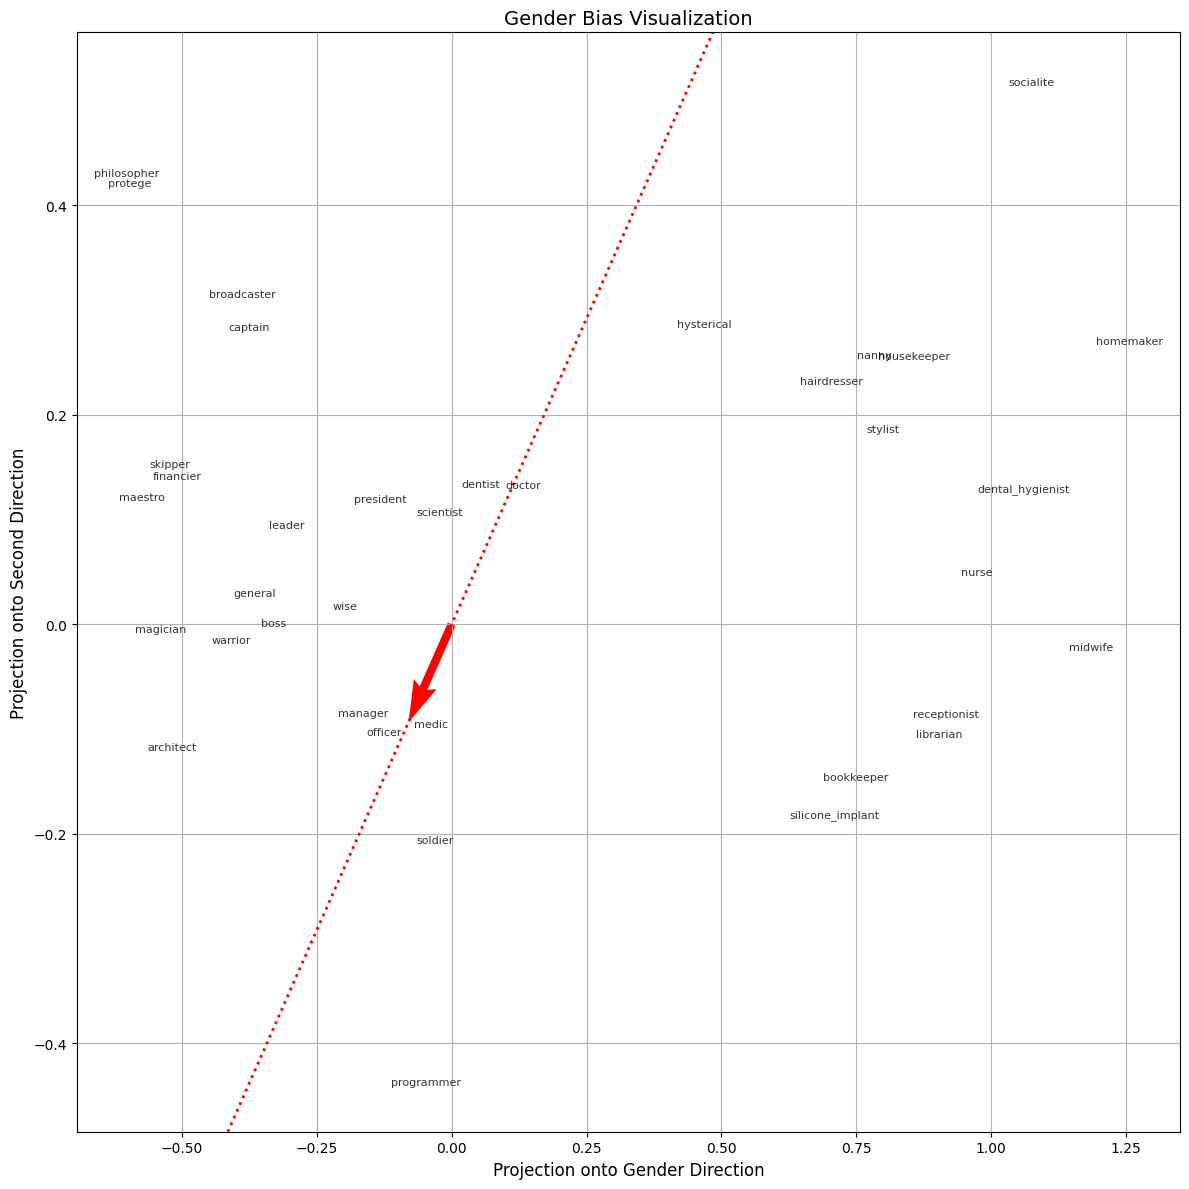

In [ ]:
gender_direction = find_gender_direction()
plot_gender_bias_xy(gender_biased_words, gender_direction)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

def plot_gender_bias_tsne(biased_words, gender_direction):
    """Plots gender-biased words using t-SNE."""

    vectors = []
    labels = []
    for word in biased_words:
        if word in model:
            vectors.append(model[word])
            labels.append(word)

    vectors = np.array(vectors)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0,perplexity=20)
    reduced_vectors = tsne.fit_transform(vectors)

    # Calculate gender projections
    gender_projections = {}
    for i, word in enumerate(labels):
        gender_projections[word] = np.dot(vectors[i], gender_direction)

    # Color coding based on gender projections
    colors = [gender_projections[word] for word in labels]

    # Plotting
    plt.figure(figsize=(18,12))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=colors, cmap="PRGn")
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

    plt.colorbar(label="Projection onto Gender Direction")
    plt.title("Gender Bias Visualization (t-SNE)")
    plt.show()

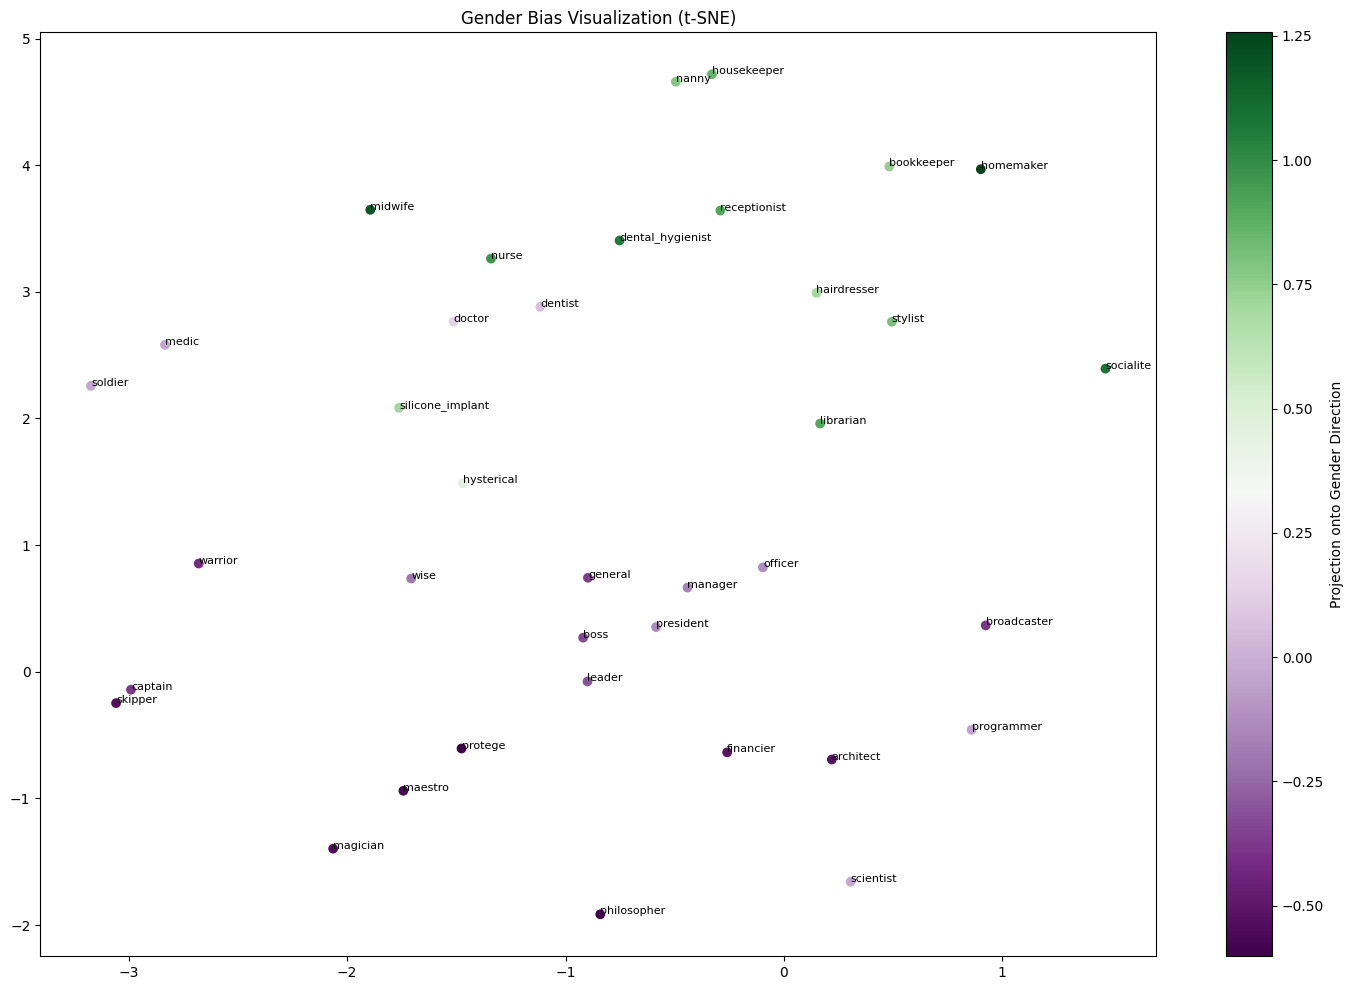

In [ ]:
gender_direction = find_gender_direction()
plot_gender_bias_tsne(gender_biased_words, gender_direction)